# Przygotowanie środowiska badawczego 🔬📓

### Notebook przewidziany jest do odpalania jako całość od zera, więc nie ma obaw że rzeczy wcześniej utworzone będą utworzone po raz kolejny 😌😌😌

### Task: https://enalpha.atlassian.net/browse/EN-529

### Spis:
1. Utworzenie nowego węzła na środowisku DEV ✅
2. Skopiowanie danych żródłowych z noda 7 środowisko produkcyjne ) do środowiska DEV  ✅
3. Skomponowanie ciągłości danych. Czy dla tego node’a mamy np nieprzerwane 6 miesięcy danych? ✅
4. Podzielenie dostępnych okresów czasowych na specjalne okresy treningowe z następującymi po nich okresami sprawdzającymi. ✅

## Zadania ✔️

In [1]:
import os
import sys

sys.path.append("..")

from dotenv import load_dotenv

load_dotenv("../common/.env_development")

from contextlib import contextmanager

from common import config


@contextmanager
def prod_credentials():
    try:
        os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.environ[
            "CREDENTIALS_PROD_CONTAINER_PATH"
        ]
        yield
    finally:
        os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.environ[
            "CREDENTIALS_DEV_CONTAINER_PATH"
        ]

### Utworzenie nowego węzła na środowisku DEV ✅

#### Stałe:

In [2]:
LOCATION_ID = 529
ACTIVE_FROM = "2020-01-01T00:00:00.000Z"
LOCATION = {
    "id": LOCATION_ID,
    "building": "7",
    "city": 950463,
    "country": "Poland",
    "lat": 50.0465,
    "lon": 19.9825,
    "post_code": "32-031",
    "street": 950463,
}


NODE_CREATION_REQUEST_BODY = {
    "active_from": ACTIVE_FROM,
    "location": LOCATION,
}

METERS_CREATION_REQUEST_BODIES = [
    {
        "active_from": ACTIVE_FROM,
        "gateway_id": "GW2006010007",
        "meter_id": "dom_adam",
        "model": "fif",
        "role": "input_home",
    },
    {
        "active_from": ACTIVE_FROM,
        "gateway_id": "GW2006010007",
        "meter_id": "inverter_adam",
        "model": "fif",
        "role": "inverter",
    },
]

#### Utwórzmy węzeł dla stałej lokalizacji jeśli nie istnieje

In [3]:
from common.controllers.nodes_controller import NodesController

nodes_controller = NodesController()

response = nodes_controller.get_all_nodes(location=LOCATION_ID)
assert response.status_code == 200

if not response.json():
    response = nodes_controller.create_node(NODE_CREATION_REQUEST_BODY)
    assert response.status_code == 201
    print("Succesfully created node")
else:
    node = response.json()[0]
    print(f"Node was already created! Id: {node['id']}")

Node was already created! Id: 503


#### Dodajmy mierniki do tego węzła jeśli nie istnieją

In [4]:
response = nodes_controller.get_node(node_id=node["id"], full=True)
assert response.status_code == 200

if len((meters := response.json()["meters"])) < len(METERS_CREATION_REQUEST_BODIES):
    print(f"No meters for node {node['id']}, adding...")
    for meter_request_body in METERS_CREATION_REQUEST_BODIES:
        nodes_controller.create_meter(
            node_id=node["id"], request_body=meter_request_body
        )
else:
    print("Meters were already added!")

full_node = nodes_controller.get_node(node_id=node["id"], full=True).json()
print("\nNode: \n")
full_node

Meters were already added!

Node: 



{'active_from': '2020-01-01T00:00:00',
 'id': 503,
 'location': {'building': '7',
  'city': 950463,
  'country': 'Poland',
  'id': 529,
  'lat': 50.0465,
  'lon': 19.9825,
  'post_code': '32-031',
  'street': 950463},
 'meters': [{'active_from': '2020-01-01T00:00:00',
   'anomalies': [],
   'gateway_id': 'GW2006010007',
   'id': 808,
   'meter_id': 'dom_adam',
   'model': 'fif',
   'role': 'input_home'},
  {'active_from': '2020-01-01T00:00:00',
   'anomalies': [],
   'gateway_id': 'GW2006010007',
   'id': 809,
   'meter_id': 'inverter_adam',
   'model': 'fif',
   'role': 'inverter'}]}

### Skopiowanie danych żródłowych z noda 7 (środowisko produkcyjne) do środowiska DEV ✅

#### Załadowanie danych do BigQuery jeśli jeszcze nie zostało to zrobione

In [5]:
def get_table_fields(client, table_id):
    table_ref = client.get_table(table_id)
    return ["{0}".format(schema.name, schema.field_type) for schema in table_ref.schema]

In [6]:
import datetime

from google.cloud import bigquery

electrical_measurements_table_ids = {}
electrical_measurements_table_ids[
    "dev"
] = f"{config.PROJECT_ID}.{config.BIGQUERY_DATASET_NAME}.{config.BIGQUERY_TABLE_ELECTRICAL_MEASUREMENTS}"
electrical_measurements_table_ids[
    "prod"
] = f"pwrability-prod.{config.BIGQUERY_DATASET_NAME}.{config.BIGQUERY_TABLE_ELECTRICAL_MEASUREMENTS}"

gateway_ids = [x["gateway_id"] for x in full_node["meters"]]

assert (
    len(set(gateway_ids)) == 1
), "There are multiple gateways, query below doesn't support it"
gateway_id = gateway_ids[0]

n_of_rows = {}
for environment in electrical_measurements_table_ids.keys():
    print(
        f"Doing n_of_rows check in BigQuery for rows with gateway_id = {gateway_id} on environment: {environment}"
    )
    query = f"""
            SELECT timestamp
            FROM `{electrical_measurements_table_ids[environment]}`
            WHERE gateway_id='{gateway_id}' ORDER BY timestamp
            """

    if environment == "prod":
        with prod_credentials():
            client = bigquery.Client()

    else:
        client = bigquery.Client()
    query_job = client.query(query)
    result = query_job.result()

    n_of_rows[environment] = result.total_rows
    if n_of_rows[environment] > 0:
        start, *_, end = result
        start_date = datetime.datetime.strftime(start[0], "%Y-%m-%dT%H:%M:%SZ")
        end_date = datetime.datetime.strftime(end[0], "%Y-%m-%dT%H:%M:%SZ")

    print(f"Number of rows: {n_of_rows[environment]}")

if n_of_rows["dev"] == 0:
    print("No rows on dev environment, execute this query in Web Console: \n")
    print("QUERY TO EXECUTE: \n\n")
    client = bigquery.Client()
    fields = get_table_fields(client, electrical_measurements_table_ids["dev"])

    fields_query_batch = ", ".join(["`" + x + "`" for x in fields])

    query_to_run_in_console = " ".join(
        f"""
                              INSERT INTO {electrical_measurements_table_ids["dev"]}({fields_query_batch})
                              SELECT {fields_query_batch} FROM {electrical_measurements_table_ids["prod"]}
                              WHERE gateway_id='{gateway_id}'
                              """.split()
    )
    print(query_to_run_in_console)
elif n_of_rows["dev"] < n_of_rows["prod"]:
    print(
        "Rows mismatch between environments, it can indicate that data was already loaded to DEV, but it was kept getting updated on PROD"
    )
elif n_of_rows["dev"] == n_of_rows["prod"]:
    print("Everything is all set!")
else:
    print("Something is wrong - check your BigQuery")

Doing n_of_rows check in BigQuery for rows with gateway_id = GW2006010007 on environment: dev
Number of rows: 331175
Doing n_of_rows check in BigQuery for rows with gateway_id = GW2006010007 on environment: prod
Number of rows: 331175
Everything is all set!


### Skomponowanie ciągłości danych. Czy dla tego node’a mamy np nieprzerwane 6 miesięcy danych? ✅

#### Do podglądnięcia rzeczywistych danych dla wybranego 'endogenous', możemy wykorzystać nasze ML API i flagę **debug** 🏁🛠️

In [7]:
import copy

from common.controllers.ml_controller import MLController

sys.path.append(
    "../tests"
)  # we need to do that because we collide with some 'tests' package embedded in this docker image
from helpers import (
    MLModelsStorageController,
    assert_task_is_scheduled,
    assert_training_response,
)

In [8]:
ml_controller = MLController()
storage_controller = MLModelsStorageController()

CREATE_MODEL_REQUEST_BODY_TEMPLATE = {
    "algorithm": "boosted_trees",
    "optimization_metric": "r2",
    "horizon": "1d",
    "training_data": {
        "node": full_node["id"],
        "endogenous": None,
        "time_range_start": start_date,
        "time_range_end": end_date,
    },
    "target_frequency": "1h",
    "debug": True,
}
ENDOGENOUSES = ["energy_usage", "real_energy_prod"]


MODEL_ID = None # Some cached model id which can be used "2a9d1af6-d4ce-4d7e-964c-7837fa99a8dc"

real_data_dfs = {}
for endogenous in ENDOGENOUSES:
    if not MODEL_ID:
        request_body = copy.deepcopy(CREATE_MODEL_REQUEST_BODY_TEMPLATE)
        request_body["training_data"]["endogenous"] = endogenous
        response = ml_controller.create_and_train_model(request_body)
        task_id = assert_task_is_scheduled(response)
        response = ml_controller.wait_for_task(task_id, timeout=15 * 60)
        model_id, r2 = assert_training_response(response)
    else:
        model_id = MODEL_ID
    # Make sure model and its metadata are stored in Cloud Storage
    assert storage_controller.check_ml_model_exists_in_cloud_storage(model_id)

    # Get dataframe model was trained on
    real_data_dfs[endogenous] = storage_controller.get_ml_model_intermediate_data_to_df(
        model_id, {"moment": "post", "target": "exog"}
    )

Creating model with request body {'algorithm': 'boosted_trees', 'optimization_metric': 'r2', 'horizon': '1d', 'training_data': {'node': 503, 'endogenous': 'energy_usage', 'time_range_start': '2020-07-16T17:18:47Z', 'time_range_end': '2021-11-04T18:37:35Z'}, 'target_frequency': '1h', 'debug': True}...
Waiting for task of id 65029dc2-01f6-4ee1-b74a-867c4fbba6a7 to finish


INFO:common.controllers.ml_controller:Waiting for task of id 65029dc2-01f6-4ee1-b74a-867c4fbba6a7 to finish


Waiting. Status: STARTED


INFO:common.controllers.ml_controller:Waiting. Status: STARTED


Waiting. Status: STARTED


INFO:common.controllers.ml_controller:Waiting. Status: STARTED


Task finished!


INFO:common.controllers.ml_controller:Task finished!


Creating model with request body {'algorithm': 'boosted_trees', 'optimization_metric': 'r2', 'horizon': '1d', 'training_data': {'node': 503, 'endogenous': 'real_energy_prod', 'time_range_start': '2020-07-16T17:18:47Z', 'time_range_end': '2021-11-04T18:37:35Z'}, 'target_frequency': '1h', 'debug': True}...


INFO:common.controllers.ml_controller:Creating model with request body {'algorithm': 'boosted_trees', 'optimization_metric': 'r2', 'horizon': '1d', 'training_data': {'node': 503, 'endogenous': 'real_energy_prod', 'time_range_start': '2020-07-16T17:18:47Z', 'time_range_end': '2021-11-04T18:37:35Z'}, 'target_frequency': '1h', 'debug': True}...


Waiting for task of id 29f7b2c7-ae40-4d71-a3f6-15aea3c17d5b to finish


INFO:common.controllers.ml_controller:Waiting for task of id 29f7b2c7-ae40-4d71-a3f6-15aea3c17d5b to finish


Waiting. Status: STARTED


INFO:common.controllers.ml_controller:Waiting. Status: STARTED


Task finished!


INFO:common.controllers.ml_controller:Task finished!


#### Mając nasze dane rzeczywiste, możemy przystąpić do analizy 🔍🔍🔍

##### Funkcje pomocnicze do generowania raportu

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Markdown, display


def create_raport_and_get_biggest_valid_df(df):
    EPS_TO_CONSIDER_MEASUREMENT_AS_MISSING = 1e-3  # so if we will have measurement: energy_usage: 0.002 - this will be treated as 0
    PERCENTAGE_OF_PLUS_VALUES_TO_ALL_VALUES_TO_CONSIDER_MEASUREMENT_VALIS = 95
    NUMBER_OF_HOURS_IN_A_DAY_MISSING_TO_CONSIDER_MEASUREMENT_INVALID = 23

    _df = df.copy()
    endogenous = df.columns[0]

    _df["plus"] = _df[endogenous].apply(lambda x: x if x > 0 else 0)
    _df["minus"] = _df[endogenous].apply(lambda x: -x if x < 0 else 0)
    _df["missing"] = _df[endogenous].apply(
        lambda x: 1 if EPS_TO_CONSIDER_MEASUREMENT_AS_MISSING > abs(0 - x) else 0
    )
    temp_df = _df.resample("1d").sum()

    new_df = pd.DataFrame(
        100 * (temp_df["plus"] / (temp_df["plus"] + temp_df["minus"])),
        columns=["percentage_of_plus"],
    )
    new_df["missing"] = temp_df["missing"]

    new_df["valid"] = (
        new_df["percentage_of_plus"].apply(
            lambda x: 1
            if x > PERCENTAGE_OF_PLUS_VALUES_TO_ALL_VALUES_TO_CONSIDER_MEASUREMENT_VALIS
            else 0
        )
        + new_df["missing"].apply(
            lambda x: 1
            if x < NUMBER_OF_HOURS_IN_A_DAY_MISSING_TO_CONSIDER_MEASUREMENT_INVALID
            else 0
        )
        == 2
    )

    valid_values = [new_df.loc[str(x.date())].valid for x in _df[endogenous].index]

    a = new_df.valid != 0
    cummulated_with_reset = a.cumsum() - a.cumsum().where(~a).ffill().fillna(0).astype(
        int
    )
    max_val = cummulated_with_reset.max()
    max_idx = list(cummulated_with_reset.values).index(max_val)
    biggest_range = slice(max_idx - max_val, max_idx)

    new_df_filtered = new_df.iloc[biggest_range]
    result = df[slice(new_df_filtered.iloc[0].name, new_df_filtered.iloc[-1].name)]

    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(df[endogenous])
    ax.plot(df[endogenous].index, [0] * len(_df[endogenous]), color="r", linewidth=3)
    ax.bar(
        df[endogenous].index,
        [5 if x else 0 for x in valid_values],
        color="g",
        alpha=0.02,
    )
    ax.bar(result.index, 5, color="g", alpha=0.04)
    ax.set_title(f"{endogenous} dla wybranego węzła", fontsize=20)
    ax.set_ylabel(f"{endogenous} [kW]", fontsize=15)
    ax.set_xlabel("Data", fontsize=15)

    display(
        Markdown(
            f"""<h1>
     6 miesięcy nieprzerwanych danych {"✅" if max_val >=182 else "❌"} ({max_val} dni)
    </h1>
    """
        )
    )

    return result

In [10]:
valid_dfs = {}

##### Zużycie energii 📊⚡

<h1>
     6 miesięcy nieprzerwanych danych ✅ (255 dni)
    </h1>
    

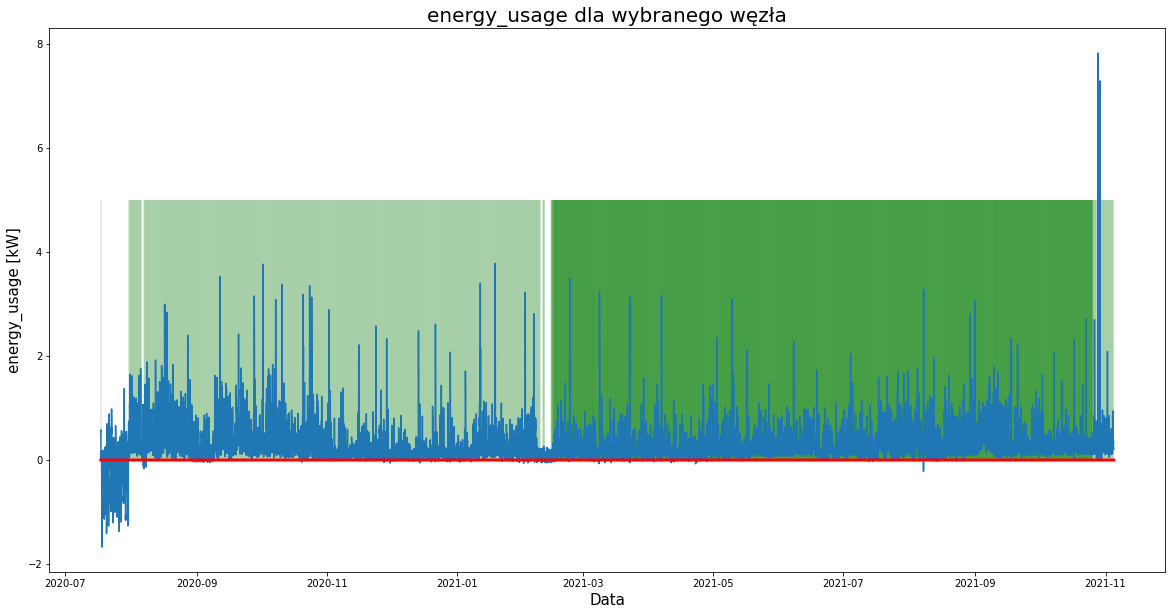

In [11]:
valid_dfs["energy_usage"] = create_raport_and_get_biggest_valid_df(
    real_data_dfs["energy_usage"]
)

##### Produkcja energii 📊☀️

<h1>
     6 miesięcy nieprzerwanych danych ✅ (255 dni)
    </h1>
    

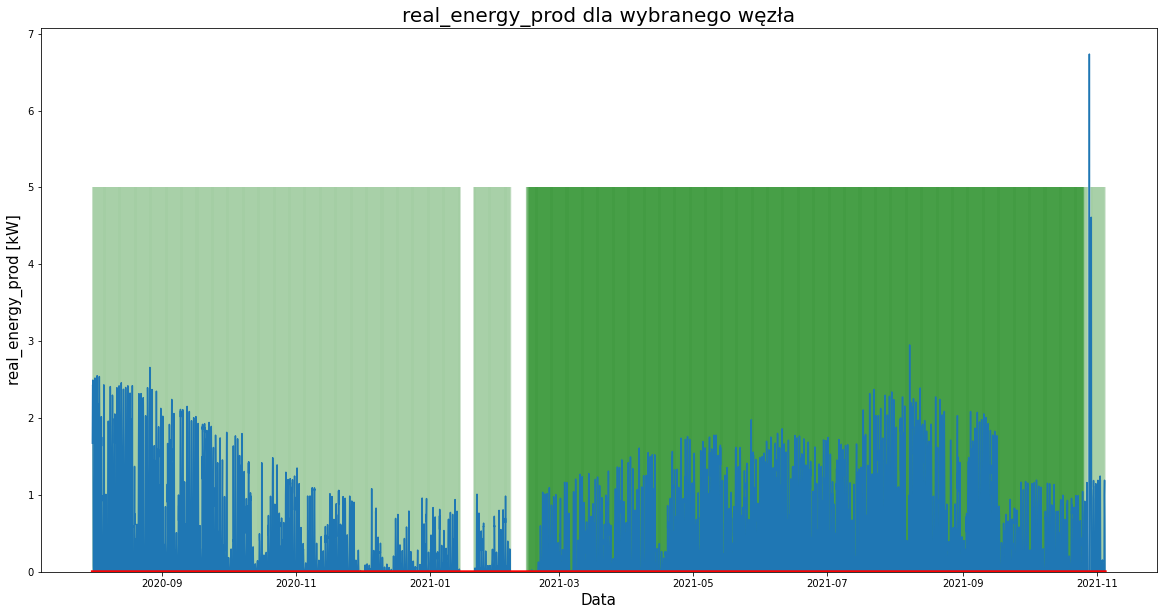

In [12]:
valid_dfs["real_energy_prod"] = create_raport_and_get_biggest_valid_df(
    real_data_dfs["real_energy_prod"]
)

### Podzielenie dostępnych okresów czasowych na specjalne okresy treningowe z następującymi po nich okresami sprawdzającymi. ✅

In [13]:
from helpers import PredictionsParser
from sklearn.model_selection import TimeSeriesSplit

In [14]:
def generate_samples(df, days_to_predict=1):
    """We assume target frequency is 1h (input df is resampled using '1h' resampling interval)"""
    tscv = TimeSeriesSplit(
        n_splits=int(len(df) / (24 * days_to_predict) - 3 * days_to_predict),
        test_size=days_to_predict * 24,
    )
    for train_index, test_index in tscv.split(df):
        train_df, test_df = df.iloc[train_index], df.iloc[test_index]
        yield {
            "time_range_start": train_df.iloc[0].name.isoformat().split("+")[0] + "Z",
            "time_range_end": train_df.iloc[-1].name.isoformat().split("+")[0] + "Z",
            "predict_time_range_start": test_df.iloc[0].name.isoformat().split("+")[0]
            + "Z",
            "prediction_horizon": f"{days_to_predict}d",
            "training_data": train_df,
            "real_predictions": test_df,
        }

#### Przykład użycia

Creating model with request body {'algorithm': 'boosted_trees', 'optimization_metric': 'r2', 'horizon': '1d', 'training_data': {'node': 503, 'endogenous': 'real_energy_prod', 'time_range_start': '2021-02-14T00:00:00Z', 'time_range_end': '2021-08-10T00:00:00Z'}, 'target_frequency': '1h', 'debug': False}...


INFO:common.controllers.ml_controller:Creating model with request body {'algorithm': 'boosted_trees', 'optimization_metric': 'r2', 'horizon': '1d', 'training_data': {'node': 503, 'endogenous': 'real_energy_prod', 'time_range_start': '2021-02-14T00:00:00Z', 'time_range_end': '2021-08-10T00:00:00Z'}, 'target_frequency': '1h', 'debug': False}...


Waiting for task of id a3953784-e5ab-4794-84b2-96ef47ef265b to finish


INFO:common.controllers.ml_controller:Waiting for task of id a3953784-e5ab-4794-84b2-96ef47ef265b to finish


Waiting. Status: STARTED


INFO:common.controllers.ml_controller:Waiting. Status: STARTED


Task finished!


INFO:common.controllers.ml_controller:Task finished!


Doing predictions using model ae586f46-4b44-4849-8e02-a1c4a58c4f12 with request body {'prediction_time_start': '2021-08-10T01:00:00Z', 'prediction_horizon': '7d'}...


INFO:common.controllers.ml_controller:Doing predictions using model ae586f46-4b44-4849-8e02-a1c4a58c4f12 with request body {'prediction_time_start': '2021-08-10T01:00:00Z', 'prediction_horizon': '7d'}...


Waiting for task of id 8b100bd0-ce27-4a31-a371-4ccc271ad7fe to finish


INFO:common.controllers.ml_controller:Waiting for task of id 8b100bd0-ce27-4a31-a371-4ccc271ad7fe to finish


Task finished!


INFO:common.controllers.ml_controller:Task finished!


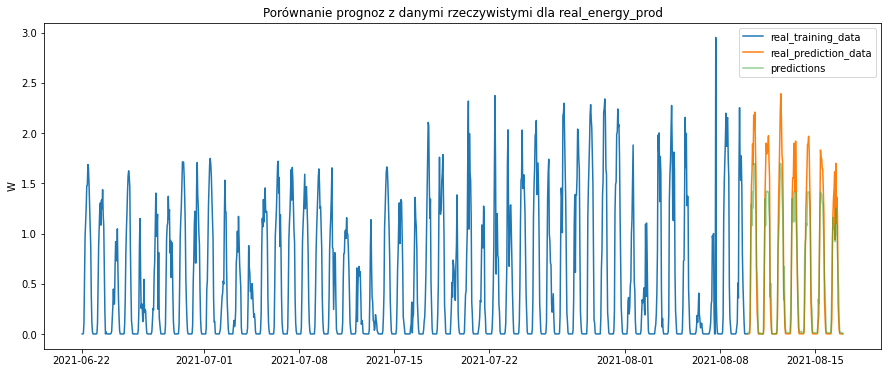

In [15]:
endogenous = "real_energy_prod"
days_to_predict = 7
sample_number = 4

samples = generate_samples(valid_dfs[endogenous], days_to_predict=days_to_predict)


for idx, sample in enumerate(samples):
    if idx!=sample_number:
        continue
    request_body = copy.deepcopy(CREATE_MODEL_REQUEST_BODY_TEMPLATE)

    request_body["training_data"]["endogenous"] = endogenous
    request_body["training_data"]["time_range_start"] = sample["time_range_start"]
    request_body["training_data"]["time_range_end"] = sample["time_range_end"]
    request_body["debug"] = False

    predict_request_body = {
        "prediction_time_start": sample["predict_time_range_start"],
        "prediction_horizon": f"{days_to_predict}d",
    }

    response = ml_controller.create_and_train_model(request_body)
    task_id = assert_task_is_scheduled(response)
    response = ml_controller.wait_for_task(task_id, timeout=15 * 60, refresh_time=5)
    model_id, r2 = assert_training_response(response)

    response = ml_controller.predict(model_id, predict_request_body)
    task_id = assert_task_is_scheduled(response)

    response = ml_controller.wait_for_task(task_id, timeout=5 * 60, refresh_time=5)

    predictions_df = PredictionsParser.create_predictions_dataframe(response.json())
    
    plt.plot(sample['training_data'][-24*days_to_predict*7:], label='real_training_data')
    plt.plot(sample['real_predictions'], label='real_prediction_data' )
    plt.plot(predictions_df, label='predictions', alpha=0.5)
    plt.legend()
    plt.title(f'Porównanie prognoz z danymi rzeczywistymi dla {endogenous}')
    plt.ylabel('W')